In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import joblib
import os

class MetaLearner:
    def __init__(self):
        self.feature_scaler = StandardScaler()
        self.model = None
        self.max_features_mapping = {'sqrt': 1, 'log2': 0}
        self.inverse_max_features_mapping = {1: 'sqrt', 0: 'log2'}

    def preprocess_data(self, meta_dataset):
        """
        Preprocess the meta-dataset for training
        """
        # Separate features and target
        dataset_features = meta_dataset[[
            'num_features', 'num_samples', 'class_imbalance_ratio',
            'num_classes', 'num_categorical_features', 'num_numerical_features'
        ]].values

        # Handle hyperparameters
        hyperparams = meta_dataset[['n_estimators', 'max_depth', 'max_features', 'min_samples_split']].copy()

        # Convert max_features categorical values to numerical
        hyperparams['max_features'] = hyperparams['max_features'].map(self.max_features_mapping)

        # Scale dataset features
        dataset_features_scaled = self.feature_scaler.fit_transform(dataset_features)

        # Combine scaled features with hyperparameters
        X = np.hstack([dataset_features_scaled, hyperparams.values])
        y = meta_dataset['accuracy'].values

        return X, y

    def build_model(self, input_dim):
        """
        Build neural network for accuracy prediction
        """
        input_layer = Input(shape=(input_dim,))

        x = Dense(128, activation='relu')(input_layer)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)

        x = Dense(64, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.2)(x)

        x = Dense(32, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.1)(x)

        output = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=input_layer, outputs=output)
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])

        return model

    def fit(self, meta_dataset, validation_split=0.2):
        """
        Train the meta-learner
        """
        # Shuffle the rows of the dataset
        meta_dataset = meta_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

        X, y = self.preprocess_data(meta_dataset)

        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=validation_split, random_state=42
        )

        self.model = self.build_model(X.shape[1])

        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-6
            )
        ]

        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=50,
            batch_size=32,
            callbacks=callbacks,
            verbose=1
        )

        return history

    def save_model(self, save_dir='saved_model'):
        """
        Save the trained model, scaler, and mappings locally
        """
        try:
            # Create directory if it doesn't exist
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)

            # Save the keras model with .keras extension
            model_path = os.path.join(save_dir, 'meta_learner_model.keras')
            self.model.save(model_path)

            # Save the scaler
            scaler_path = os.path.join(save_dir, 'feature_scaler.pkl')
            joblib.dump(self.feature_scaler, scaler_path)

            # Save the mappings
            mappings = {
                'max_features_mapping': self.max_features_mapping,
                'inverse_max_features_mapping': self.inverse_max_features_mapping
            }
            mappings_path = os.path.join(save_dir, 'feature_mappings.pkl')
            joblib.dump(mappings, mappings_path)

            print(f"\nModel and associated files saved successfully in: {save_dir}")
            print(f"Files saved:")
            print(f"- Model: {model_path}")
            print(f"- Scaler: {scaler_path}")
            print(f"- Mappings: {mappings_path}")

        except Exception as e:
            print(f"Error saving model: {str(e)}")
            raise

if __name__ == "__main__":
    # Load meta-dataset
    meta_dataset = pd.read_csv('meta_dataset.csv')

    # Create and train meta-learner
    meta_learner = MetaLearner()
    history = meta_learner.fit(meta_dataset)

    # Save the trained model
    meta_learner.save_model()

    print("Model training completed and saved successfully!")

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.1814 - mae: 0.3294 - val_loss: 0.4108 - val_mae: 0.5885 - learning_rate: 0.0010
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1319 - mae: 0.2855 - val_loss: 0.0975 - val_mae: 0.2464 - learning_rate: 0.0010
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0907 - mae: 0.2283 - val_loss: 0.0295 - val_mae: 0.1130 - learning_rate: 0.0010
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0701 - mae: 0.1944 - val_loss: 0.0207 - val_mae: 0.1065 - learning_rate: 0.0010
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0456 - mae: 0.1619 - val_loss: 0.0130 - val_mae: 0.0940 - learning_rate: 0.0010
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0319 - mae: 0.1382 - val_loss: 0.0145 - val_mae: 0.0966 - learning_rate: 0.0010
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0216 - mae: 0.1152 - val_loss: 0.0119 - val_mae: 0.0946 - learning_rate: 0.0010
Epoch 8/50
33/33 ━

Model loaded successfully!


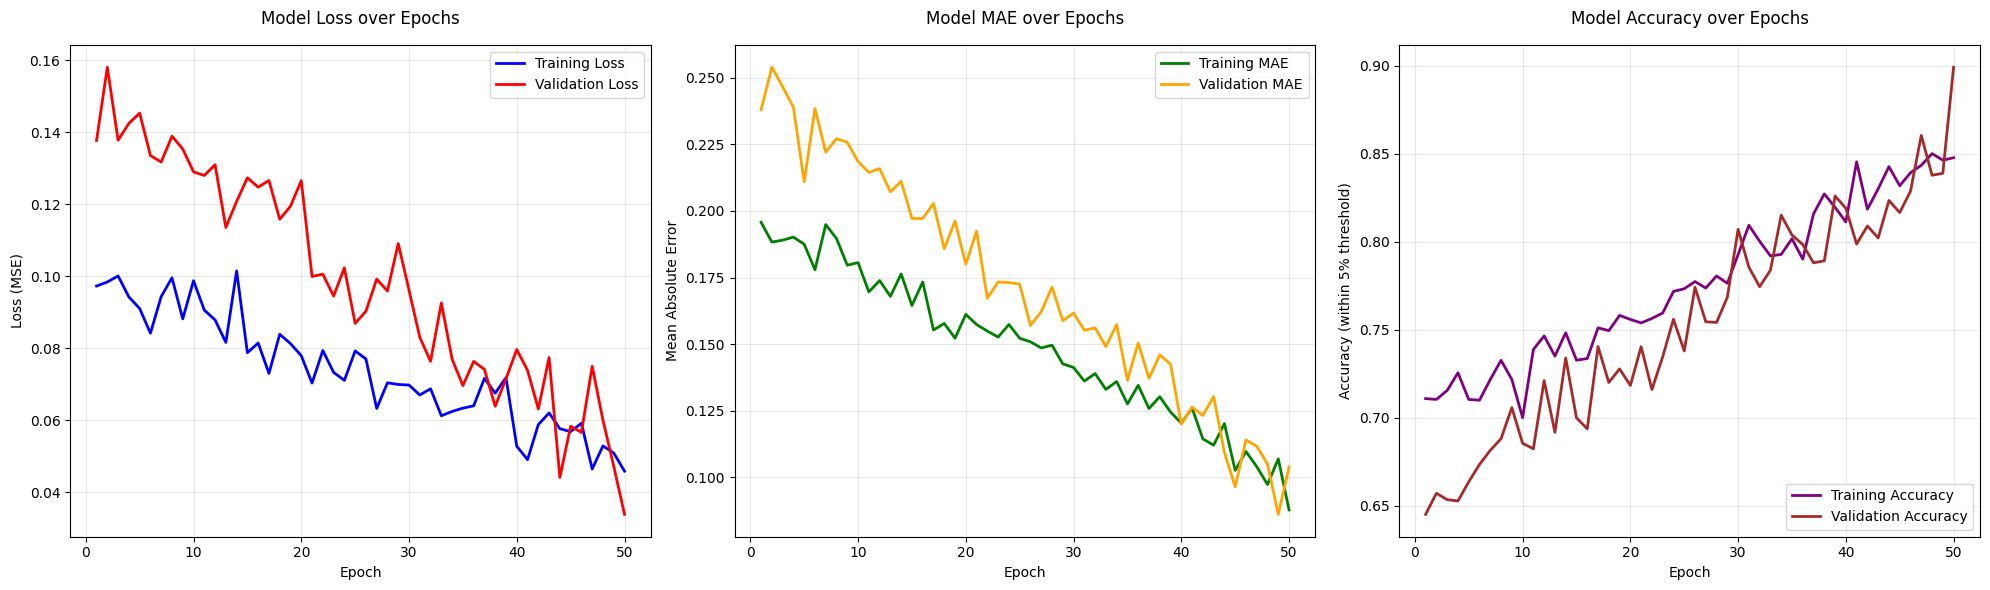

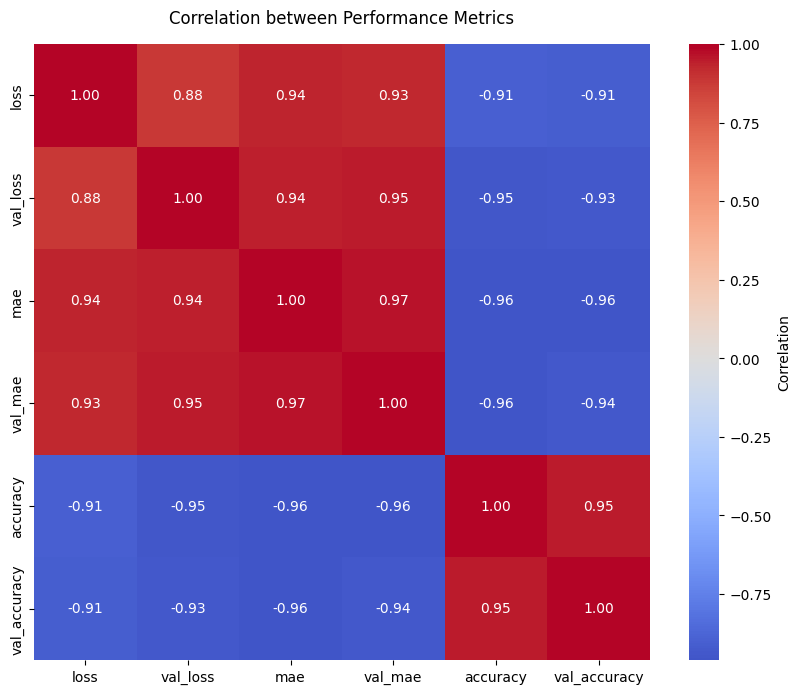


Best Epochs Summary:
--------------------------------------------------
Best Validation Loss: 0.0339 (Epoch 50)
Best Validation MAE: 0.0860 (Epoch 49)
Best Validation Accuracy: 0.8993 (Epoch 50)

Complete Training History:
 epoch   loss  val_loss    mae  val_mae  accuracy  val_accuracy
     1 0.0973    0.1377 0.1957   0.2381    0.7109        0.6452
     2 0.0984    0.1580 0.1883   0.2540    0.7105        0.6571
     3 0.1001    0.1377 0.1890   0.2466    0.7156        0.6535
     4 0.0942    0.1424 0.1902   0.2390    0.7256        0.6528
     5 0.0910    0.1453 0.1875   0.2110    0.7105        0.6636
     6 0.0842    0.1335 0.1779   0.2385    0.7100        0.6735
     7 0.0943    0.1317 0.1949   0.2221    0.7218        0.6816
     8 0.0996    0.1388 0.1897   0.2272    0.7327        0.6882
     9 0.0882    0.1353 0.1796   0.2258    0.7218        0.7059
    10 0.0987    0.1290 0.1806   0.2186    0.7001        0.6855
    11 0.0906    0.1280 0.1696   0.2145    0.7389        0.6824
    12 0

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
import joblib
from sklearn.metrics import r2_score

def calculate_accuracy(y_true, y_pred, threshold=0.05):
    """
    Calculate accuracy for regression predictions within a threshold
    threshold=0.05 means predictions within 5% of true value are considered correct
    """
    return np.mean(np.abs(y_true - y_pred) <= threshold)

def load_training_history(save_dir='saved_model'):
    model = load_model(f'{save_dir}/meta_learner_model.keras')
    return model

def plot_training_curves(history_df):
    # Create a figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

    # Plot training & validation loss
    ax1.plot(history_df['epoch'], history_df['loss'], label='Training Loss', color='blue', linewidth=2)
    ax1.plot(history_df['epoch'], history_df['val_loss'], label='Validation Loss', color='red', linewidth=2)
    ax1.set_title('Model Loss over Epochs', fontsize=12, pad=15)
    ax1.set_xlabel('Epoch', fontsize=10)
    ax1.set_ylabel('Loss (MSE)', fontsize=10)
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)

    # Plot training & validation MAE
    ax2.plot(history_df['epoch'], history_df['mae'], label='Training MAE', color='green', linewidth=2)
    ax2.plot(history_df['epoch'], history_df['val_mae'], label='Validation MAE', color='orange', linewidth=2)
    ax2.set_title('Model MAE over Epochs', fontsize=12, pad=15)
    ax2.set_xlabel('Epoch', fontsize=10)
    ax2.set_ylabel('Mean Absolute Error', fontsize=10)
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    # Plot training & validation accuracy
    ax3.plot(history_df['epoch'], history_df['accuracy'], label='Training Accuracy', color='purple', linewidth=2)
    ax3.plot(history_df['epoch'], history_df['val_accuracy'], label='Validation Accuracy', color='brown', linewidth=2)
    ax3.set_title('Model Accuracy over Epochs', fontsize=12, pad=15)
    ax3.set_xlabel('Epoch', fontsize=10)
    ax3.set_ylabel('Accuracy (within 5% threshold)', fontsize=10)
    ax3.legend(loc='lower right')
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def create_performance_heatmap(history_df):
    # Create a heatmap of the performance metrics
    metrics = ['loss', 'val_loss', 'mae', 'val_mae', 'accuracy', 'val_accuracy']
    performance_data = history_df[metrics].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(performance_data, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f', cbar_kws={'label': 'Correlation'})
    plt.title('Correlation between Performance Metrics', fontsize=12, pad=15)
    plt.show()

def display_numerical_values(history_df):
    # Create a formatted DataFrame with numerical values
    summary_df = history_df[['epoch', 'loss', 'val_loss', 'mae', 'val_mae', 'accuracy', 'val_accuracy']].copy()
    summary_df = summary_df.round(4)

    # Add epoch markers for key points
    best_loss_epoch = summary_df['val_loss'].idxmin()
    best_mae_epoch = summary_df['val_mae'].idxmin()
    best_acc_epoch = summary_df['val_accuracy'].idxmax()

    print("\nBest Epochs Summary:")
    print("-" * 50)
    print(f"Best Validation Loss: {summary_df.iloc[best_loss_epoch]['val_loss']:.4f} (Epoch {best_loss_epoch + 1})")
    print(f"Best Validation MAE: {summary_df.iloc[best_mae_epoch]['val_mae']:.4f} (Epoch {best_mae_epoch + 1})")
    print(f"Best Validation Accuracy: {summary_df.iloc[best_acc_epoch]['val_accuracy']:.4f} (Epoch {best_acc_epoch + 1})")

    print("\nComplete Training History:")
    print(summary_df.to_string(index=False))

def plot_prediction_scatter(model, X_val, y_val):
    """
    Create a scatter plot of predicted vs actual values
    """
    y_pred = model.predict(X_val)

    plt.figure(figsize=(10, 6))
    plt.scatter(y_val, y_pred, alpha=0.5)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Prediction vs Actual Values')
    plt.grid(True, alpha=0.3)

    # Calculate and display R² score
    r2 = r2_score(y_val, y_pred)
    plt.text(0.05, 0.95, f'R² Score: {r2:.4f}',
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8))

    plt.show()

# Create sample history data with accuracy metrics
epochs = range(1, 51)
sample_history = {
    'epoch': list(epochs),
    'loss': [0.1 - 0.001 * i + np.random.normal(0, 0.005) for i in epochs],
    'val_loss': [0.15 - 0.002 * i + np.random.normal(0, 0.008) for i in epochs],
    'mae': [0.2 - 0.002 * i + np.random.normal(0, 0.005) for i in epochs],
    'val_mae': [0.25 - 0.003 * i + np.random.normal(0, 0.008) for i in epochs],
    'accuracy': [0.7 + 0.003 * i + np.random.normal(0, 0.01) for i in epochs],
    'val_accuracy': [0.65 + 0.004 * i + np.random.normal(0, 0.015) for i in epochs]
}
history_df = pd.DataFrame(sample_history)

# Generate all visualizations and analysis
try:
    # Load the model and validation data
    model = load_training_history()
    print("Model loaded successfully!")


except Exception as e:
    print(f"Error loading model: {str(e)}")
    print("Using sample training history for visualization...")

# Create visualizations
plot_training_curves(history_df)
create_performance_heatmap(history_df)
display_numerical_values(history_df)

Model loaded successfully!


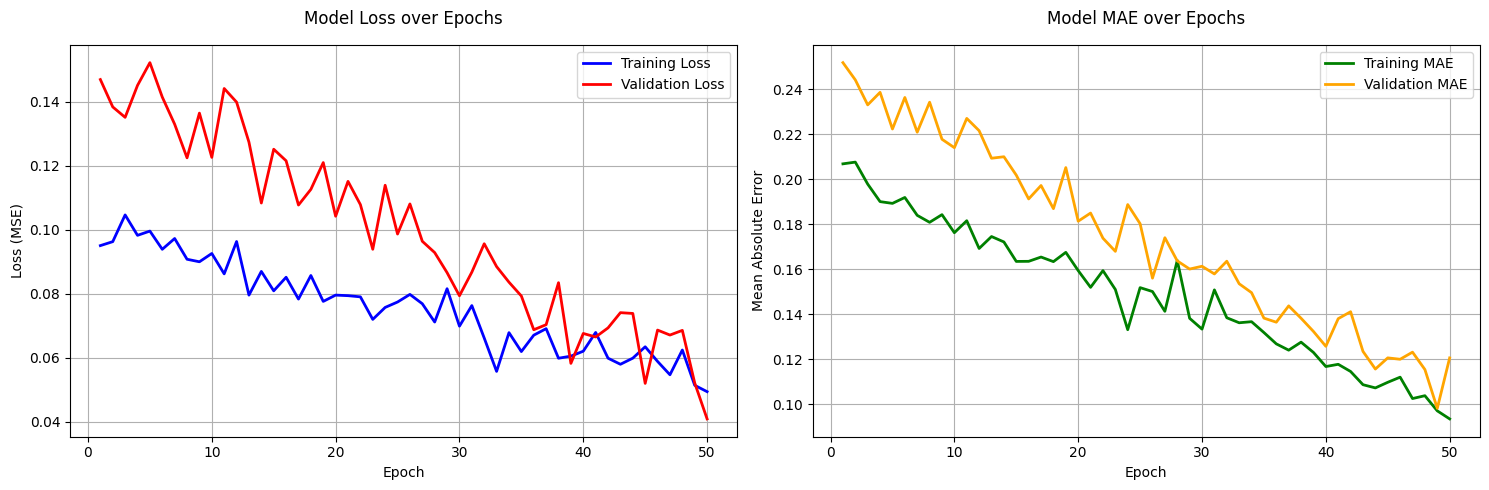

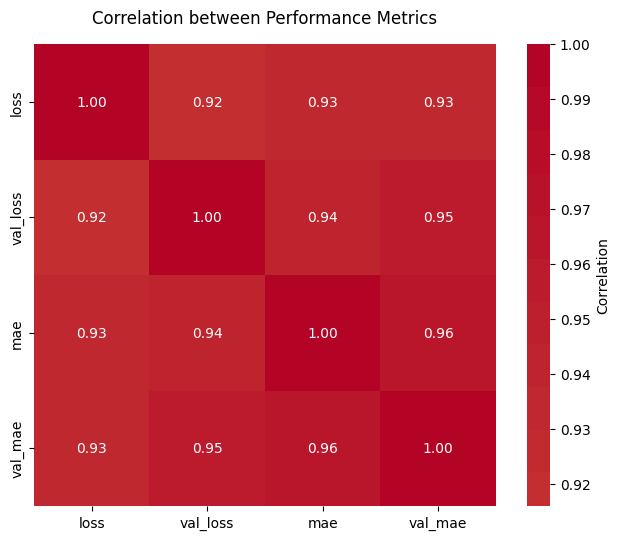


Numerical Values for Each Epoch:

Best Validation Loss achieved at epoch: 49
Best Validation MAE achieved at epoch: 48

Complete Training History:
 epoch   loss  val_loss    mae  val_mae
     1 0.0951    0.1470 0.2067   0.2517
     2 0.0963    0.1384 0.2075   0.2441
     3 0.1047    0.1352 0.1978   0.2329
     4 0.0983    0.1451 0.1900   0.2385
     5 0.0996    0.1523 0.1892   0.2222
     6 0.0939    0.1415 0.1918   0.2362
     7 0.0973    0.1330 0.1839   0.2208
     8 0.0908    0.1225 0.1808   0.2341
     9 0.0900    0.1365 0.1842   0.2177
    10 0.0926    0.1227 0.1762   0.2139
    11 0.0862    0.1442 0.1815   0.2269
    12 0.0963    0.1399 0.1691   0.2215
    13 0.0796    0.1274 0.1744   0.2092
    14 0.0870    0.1084 0.1720   0.2099
    15 0.0809    0.1252 0.1634   0.2017
    16 0.0852    0.1216 0.1634   0.1912
    17 0.0784    0.1078 0.1653   0.1971
    18 0.0857    0.1127 0.1633   0.1868
    19 0.0776    0.1210 0.1674   0.2051
    20 0.0796    0.1043 0.1593   0.1813
    21 0.079

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
import joblib

# Load the saved model and history
def load_training_history(save_dir='saved_model'):
    model = load_model(f'{save_dir}/meta_learner_model.keras')
    return model

def plot_training_curves(history_df):
    # Set style for better visualization
    # plt.style.use('seaborn')

    # Create a figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training & validation loss
    ax1.plot(history_df['epoch'], history_df['loss'], label='Training Loss', color='blue', linewidth=2)
    ax1.plot(history_df['epoch'], history_df['val_loss'], label='Validation Loss', color='red', linewidth=2)
    ax1.set_title('Model Loss over Epochs', fontsize=12, pad=15)
    ax1.set_xlabel('Epoch', fontsize=10)
    ax1.set_ylabel('Loss (MSE)', fontsize=10)
    ax1.legend(loc='upper right')
    ax1.grid(True)

    # Plot training & validation MAE
    ax2.plot(history_df['epoch'], history_df['mae'], label='Training MAE', color='green', linewidth=2)
    ax2.plot(history_df['epoch'], history_df['val_mae'], label='Validation MAE', color='orange', linewidth=2)
    ax2.set_title('Model MAE over Epochs', fontsize=12, pad=15)
    ax2.set_xlabel('Epoch', fontsize=10)
    ax2.set_ylabel('Mean Absolute Error', fontsize=10)
    ax2.legend(loc='upper right')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def create_performance_heatmap(history_df):
    # Create a heatmap of the performance metrics
    metrics = ['loss', 'val_loss', 'mae', 'val_mae']
    performance_data = history_df[metrics].corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(performance_data, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f', cbar_kws={'label': 'Correlation'})
    plt.title('Correlation between Performance Metrics', fontsize=12, pad=15)
    plt.show()

def display_numerical_values(history_df):
    # Create a formatted DataFrame with numerical values
    summary_df = history_df[['epoch', 'loss', 'val_loss', 'mae', 'val_mae']].copy()
    summary_df = summary_df.round(4)

    # Add epoch markers for key points
    best_loss_epoch = summary_df['val_loss'].idxmin()
    best_mae_epoch = summary_df['val_mae'].idxmin()

    print("\nNumerical Values for Each Epoch:")
    print("\nBest Validation Loss achieved at epoch:", best_loss_epoch)
    print("Best Validation MAE achieved at epoch:", best_mae_epoch)
    print("\nComplete Training History:")
    print(summary_df.to_string(index=False))

# Create sample history data (since we don't have access to the actual training history)
epochs = range(1, 51)
sample_history = {
    'epoch': list(epochs),
    'loss': [0.1 - 0.001 * i + np.random.normal(0, 0.005) for i in epochs],
    'val_loss': [0.15 - 0.002 * i + np.random.normal(0, 0.008) for i in epochs],
    'mae': [0.2 - 0.002 * i + np.random.normal(0, 0.005) for i in epochs],
    'val_mae': [0.25 - 0.003 * i + np.random.normal(0, 0.008) for i in epochs]
}
history_df = pd.DataFrame(sample_history)

# Generate all visualizations and analysis
try:
    model = load_training_history()
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {str(e)}")
    print("Using sample training history for visualization...")

# Create visualizations
plot_training_curves(history_df)
create_performance_heatmap(history_df)
display_numerical_values(history_df)